![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import math

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1

# Definición de la función que calcula el gini index

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del 
# árbol

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_samples=None):
    
    # Si solo es una observación
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada
    
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    
    # Continuar creando la partición
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
    # Parar si la partición resultaría en un número de muestras inferior al mínimo
    
    if min_samples is not None:
        if X_l.shape[0] < min_samples or X_r.shape[0] < min_samples:
            return tree
    
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, 
                           min_samples=min_samples)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, 
                           min_samples=min_samples)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Se entrena el árbol utilizando el subconjunto de entrenamiento

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10, 
                 min_samples=int(X_train.shape[0]*0.01))

# Se muestra la estructura del arbol entrenado

print('Estructura del árbol:')
display(tree)

# Se calculan las predicciones utilizando el subconjunto de evaluación

tree_predictions = tree_predict(X_test, tree)

# Cálculo del accuracy

from sklearn.metrics import accuracy_score

print('\nAccuracy árbol de clasificación manual =', accuracy_score(tree_predictions, y_test))

Estructura del árbol:


{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [1, 51394.909090909096],
 'n_samples': 7031,
 'gain': 0.23630504821132137,
 'sl': {'y_pred': 1,
  'y_prob': 0.8375781948168007,
  'level': 1,
  'split': [0, 2015.0],
  'n_samples': 4474,
  'gain': 0.03713896892744761,
  'sl': {'y_pred': 1,
   'y_prob': 0.6404416839199448,
   'level': 2,
   'split': [0, 2013.0],
   'n_samples': 1447,
   'gain': 0.043426293133466354,
   'sl': {'y_pred': 0,
    'y_prob': 0.2780487804878049,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 203,
    'gain': 0.05394731382546758,
    'sl': {'y_pred': 0,
     'y_prob': 0.09195402298850575,
     'level': 4,
     'split': -1,
     'n_samples': 85,
     'gain': 0.01352946029496721},
    'sr': {'y_pred': 0,
     'y_prob': 0.4166666666666667,
     'level': 4,
     'split': -1,
     'n_samples': 118,
     'gain': 0.020017026523643233}},
   'sr': {'y_pred': 1,
    'y_prob': 0.6998394863563403,
    'level': 3,
    'split': [1, 39822.0],
    


Accuracy árbol de clasificación manual = 0.8836605080831409


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2

# Creación de 10 muestras de bootstrap

np.random.seed(1)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeClassifier de sklearn

clf = DecisionTreeClassifier(max_depth=10, min_impurity_decrease=0.001, min_samples_leaf=0.01, random_state=1)

# DataFrame para guardar las predicciones de cada árbol

y_pred_bag = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test

for i, sample in enumerate(samples):
    X_train_bootstrapped = X_train.iloc[sample, :]
    y_train_bootstrapped = y_train.iloc[sample]
    clf.fit(X_train_bootstrapped, y_train_bootstrapped)
    y_pred_bag.iloc[:,i] = clf.predict(X_test)
    
# Agregación de los árboles por votación mayoritaria

manual_bagging_predictions = np.where(np.mean(y_pred_bag, axis = 1) >= 0.5, 1, 0)

# Reporte del desempeño

print('Accuracy bagging manual =', accuracy_score(manual_bagging_predictions, y_test))

Accuracy bagging manual = 0.8874133949191686


#### Comentarios sobre los resultados

Luego de entrenar el modelo bagging con 10 árboles de clasificación, utilizando los mismos criterios de parada que para el árbol individual manual, se observa un ligero incremento en el Accuracy hacia 0.8874, desde 0.8837.Así, se confirma el principio que indica que la agregación de modelos resulta en un desempeño mejor que el modelo individual y que el modelo bagging obtiene resultados relativamente buenos y podría servir para realizar la clasificación.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [7]:
# Celda 3

# Definición del modelo bagging con sklearn

from sklearn.ensemble import BaggingClassifier

n_features = X.shape[1]

clf = BaggingClassifier(DecisionTreeClassifier(max_depth=10, min_impurity_decrease=0.001, 
                                               min_samples_leaf=0.01, random_state=1),
                        n_estimators=10, max_features=int(math.log(n_features, 2)), 
                        bootstrap=True, oob_score=True, random_state=1)

# Entrenamiento del modelo bagging con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo bagging con sklearn

bagging_predictions = clf.predict(X_test)

# Reporte del desempeño

print('Accuracy bagging con sklearn =', accuracy_score(bagging_predictions, y_test))

Accuracy bagging con sklearn = 0.8767321016166282


#### Comentarios sobre los resultados

Luego de entrenar el modelo bagging de scikitlearn, con 10 árboles de clasificación y un max_features igual al resultado aproximado del logaritmo en base 2 de 9 predictores, el modelo nos entrega un Accuracy con un valor 0.8773.

Aunque los resultados del modelo siguen siendo adecuados para realizar la clasificación, el accuracy obtenido disminuye en cerca de 1% con respecto al obtenido con el Bagging manual realizado en el punto 2. Esto nos sugiere que limitar el número de parámetros a tener en cuenta para encontrar la mejor división no fue la mejor estrategia. De igual forma, podríamos explorar el tunning de los parametros y obtener valores superiores del accuracy con bagging al modificar este parámetro.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [8]:
# Celda 4

# Definición del modelo random forest con sklearn

from sklearn.ensemble import RandomForestClassifier

n_features = X.shape[1]

clf = RandomForestClassifier(max_depth = 10, min_impurity_decrease=0.001, 
                             min_samples_leaf=0.01, random_state=1,
                             n_estimators=10, max_features="log2")

# Entrenamiento del modelo random forest con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo random forest con sklearn

rf_predictions = clf.predict(X_test)

# Reporte del desempeño
Acc_RF=accuracy_score(rf_predictions, y_test)
print('Accuracy random forest con sklearn =', accuracy_score(rf_predictions, y_test))

Accuracy random forest con sklearn = 0.8804849884526559


#### Comentarios sobre los resultados

Luego de entrenar el modelo random forest de scikitlearn (utilizando los mismos parámetros para los árboles que los utilizados para el bagging con sklearn), se obtiene un Accuracy con un valor de 0.8805. Lo anterior representa una ligera mejora con respecto a los resultados obtenidos a través de bagging con skleaern. No obstante, el accuracy es inferior al obtenido con el árbol individual y con bagging manual. Esto puede ser indicación de que el modelo requiere de calibración. Aún así, los resultados del accuracy son relativamente satisfactorios y se podría usar el modelo para la clasificiación.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

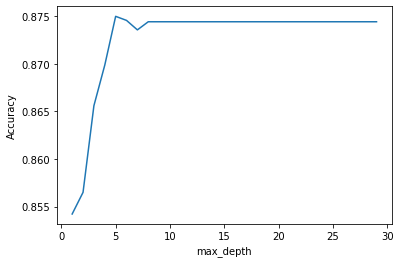

La calibración indica que el mejor accuracy ( 0.87498504784689 ) se obtiene con una profundidad máxima de 5


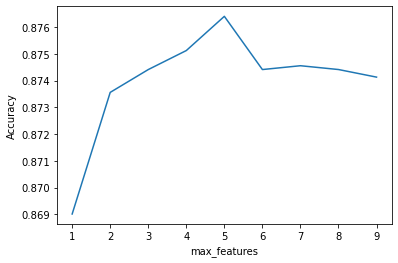

La calibración indica que el mejor accuracy ( 0.8764073208974527 ) se obtiene con un número máximo de predictores de 5


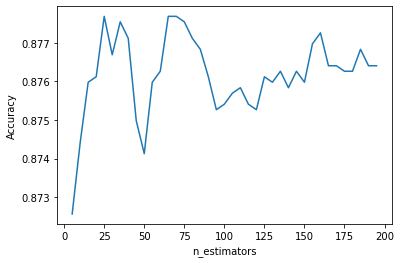

La calibración indica que el mejor accuracy ( 0.8776877505495927 ) se obtiene con un número máximo de predictores de 25
Accuracy random forest calibrado con sklearn = 0.8877020785219399


In [9]:
# Celda 5
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def cal_max_depth(inicial, final, paso): 
    
    # Creación de lista de valores para iterar sobre diferentes valores de n_estimators
    estimator_range = range(inicial,final,paso)

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
    accuracy_scores = []

    # Uso de un 10-fold cross-validation para cada valor de n_estimators
    for estimator in estimator_range:
        clf = RandomForestClassifier(max_depth=estimator, min_impurity_decrease=0.001, 
                                     min_samples_leaf=0.01, random_state=1,
                                     n_estimators=10, max_features="log2",  n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

    # Gráfica del desempeño del modelo vs la cantidad de n_estimators
    plt.plot(estimator_range, accuracy_scores)
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show()

    optimal_max_depth = inicial + (paso * np.argmax(accuracy_scores))

    return np.amax(accuracy_scores), optimal_max_depth

optimal_accuracy, optimal_max_depth = cal_max_depth(1, 30, 1)

print("La calibración indica que el mejor accuracy (", optimal_accuracy,
      ") se obtiene con una profundidad máxima de", optimal_max_depth)

def cal_n_features(n_features):

    # Creación de lista de valores para iterar sobre diferentes valores de max_features
    feature_range = range(1, n_features+1)

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
    accuracy_scores = []

    # Uso de un 10-fold cross-validation para cada valor de max_features
    for feature in feature_range:
        clf = RandomForestClassifier(max_depth=10, min_impurity_decrease=0.001, 
                                     min_samples_leaf=0.01, random_state=1,
                                     n_estimators=10, max_features=feature,  n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

    plt.plot(feature_range, accuracy_scores)
    plt.xlabel('max_features')
    plt.ylabel('Accuracy')
    plt.show()

    optimal_n_features = np.argmax(accuracy_scores) + 1

    return np.amax(accuracy_scores), optimal_n_features

optimal_accuracy, optimal_n_features = cal_n_features(X.shape[1])

print("La calibración indica que el mejor accuracy (", optimal_accuracy,
      ") se obtiene con un número máximo de predictores de", optimal_n_features)

def cal_n_estimators(estimators_array):

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
    accuracy_scores = []

    # Uso de un 10-fold cross-validation para cada valor de n_estimators
    for estimator in estimators_array:
        clf = RandomForestClassifier(max_depth=10, min_impurity_decrease=0.001, 
                                     min_samples_leaf=0.01, random_state=1,
                                     n_estimators=estimator, max_features="log2",  n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

    # Gráfica del desempeño del modelo vs la cantidad de n_estimators
    plt.plot(estimators_array, accuracy_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.show()

    optimal_n_estimators = estimators_array[np.argmax(accuracy_scores)]

    return np.amax(accuracy_scores), optimal_n_estimators

estimators = range(5, 200, 5)

optimal_accuracy, optimal_n_estimators = cal_n_estimators(estimators)

print("La calibración indica que el mejor accuracy (", optimal_accuracy,
      ") se obtiene con un número máximo de predictores de", optimal_n_estimators)

#Modelo con parametros calibrados
clf = RandomForestClassifier(max_depth=5, min_impurity_decrease=0.001, min_samples_leaf=0.01,
                             random_state=1, n_estimators=25, max_features=5,  n_jobs=-1)

# Entrenamiento del modelo random forest con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo random forest con sklearn

rf_predictions = clf.predict(X_test)

# Reporte del desempeño
Acc_RF_Cal=accuracy_score(rf_predictions, y_test)
print('Accuracy random forest calibrado con sklearn =', Acc_RF_Cal)

#### Comentarios sobre los resultados

Para realizar la calibración se realizaron varias iteraciones ajustando cada vez, el rango de valores que se querían probar, llegando finalmente a tener un ajuste fino. Esto se realizó con cada uno de los tres parámetros por separado.

Como se observa en las gráficas generadas:

- El incrementar la profundidad de los árboles mejora el desempeño del modelo solo hasta cierto punto. Vemos como el cross validation accuracy se estanca a partir de una profundidad de 8 o más. El ejercicio de calibración encuentra que el número óptimo* de profundidad máxima es 5.
- Con respecto al número máximo de predictores utilizados por los árboles del modelo, se observa que el óptimo se encuentra al utilizar un número ni tan bajo, ni tan alto, de predictores. Esto es consistente con la lógica detrás del modelo Random Forest, que indica que no todos los predictores deben ser utilizados para incrementar la aleatoreidad de los modelos agregados y mejorar el desempeño. Sin embargo, usar muy pocos predictores puede afectar la capacidad predictiva de los modelos subyacentes. Así, lo mejor es usar un número intermendio. En este caso, el óptimo* es utilizar un máximo de 5 predictores.
- Para el número de estimadores (árboles generados) no parece haber una relación clara entre este parámetro y el desempeño del modelo, pues la relación se observa errática. 

*Nota: Los óptimos se obtienen al calibrar los parámetros por separado, por lo que pueden ser diferentes de los óptimos reales que se obtendrían al calibrar los parámetros en conjunto.

Luego de obtener los óptimos, se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó desde 0.8804 a 0.8877, lo cual es una mejora significativa, pues lleva a que el modelo tenga un desempeño superior al del árbol individual y del bagging manual, que son los modelos con mejor desempeño hasta el momento. Esto reafirma que un modelo como RF calibrado tiene un buen desempeño. Un desempeño aún superior podría obtenerse si los parámetros se calibraran en conjunto. 

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [10]:
# Celda 6
!pip install xgboost

from xgboost import XGBClassifier
from sklearn import metrics

clf = XGBClassifier()

clf.fit(X_train, y_train, eval_metric='logloss')

y_pred = clf.predict(X_test)

Acc_XGB=metrics.accuracy_score(y_pred, y_test.values)

print("Accuracy Score:", Acc_XGB)

Accuracy Score: 0.8856812933025404


#### Comentarios sobre los resultados

Luego de entrenar el modelo Xtreme gradient Boosting (sin calibrar parámetros) se obtiene un accuracy de 0.8857 que es similar al obtenido con RandomForest calibrado, lo que nos da un indicio sobre la potencia del XGboosting. Este valor nos demuestra un buen desempeño del modelo.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [14]:
# Celda 7
from sklearn.model_selection import RandomizedSearchCV

params = {
 "learning_rate" : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.15, 0.25],
 "gamma": [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6],
 "colsample_bytree" : [ 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.7]
}

clf_tun = XGBClassifier()

tun_XGB=RandomizedSearchCV(clf_tun,param_distributions=params,n_iter=15,scoring='roc_auc',n_jobs=-1,cv=5,
                           verbose=2, random_state=1)

tun_XGB.fit(X_train, y_train,eval_metric='logloss')

display(tun_XGB.best_estimator_)

best_XGB=tun_XGB.best_estimator_

y_pred = best_XGB.predict(X_test)

Acc_XGB_cal=metrics.accuracy_score(y_pred, y_test.values)

print("Accuracy Score: ", Acc_XGB_cal)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    5.7s finished


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.35,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.6, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy Score:  0.8874133949191686


#### Comentarios sobre los resultados

Para realizar la calibración se utilizó el método RandomizedSearchCV, en donde se realizaron varias iteraciones, ajustando cada vez el rango de valores que se querían probar, llegando finalmente a tener un ajuste fino. Esto se realizó con cada los tres parámetros al tiempo, en cada iteración. 

Luego se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó desde 0.8857 a 0.8874, lo cual, aunque es una mejora poco significativa, resulta en un desempeño cercano al mejor obtenido hasta el momento.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

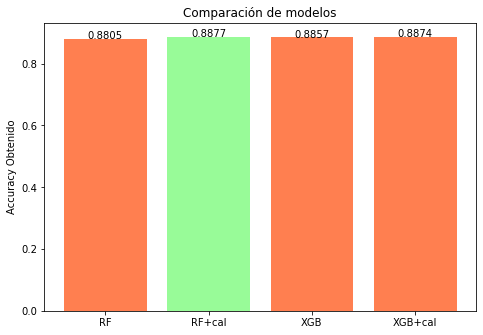

In [16]:
# Celda 8
Acc_RF
Acc_RF_Cal
Acc_XGB
Acc_XGB_cal

#Comparacion de modelos 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['RF','RF+cal','XGB','XGB+cal']
ejeY = [round(Acc_RF,4), round(Acc_RF_Cal,4), round(Acc_XGB,4), round(Acc_XGB_cal,4)]     
ax.bar(ejeX,ejeY,color=['Coral','PaleGreen','Coral','Coral'])    #color='Coral'
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.ylabel("Accuracy Obtenido")
plt.show()

#### Conclusiones

En la gráfica se comparan los valores obtenidos del Accuracy para cada modelo. De izquierda a derecha tenemos: 
Random Forest sin calibrar con 0.8805, Random Forest calibrado con 0.8877, Extreme Gradient Boosting sin calibrar con 0.8857 y finalmente, el modelo con mejor desempeño resaltado en color verde, el Extreme Gradient Boosting calibrado con 0.8874.

Estos valores fueron obtenidos haciendo las predicciones en Xtest y comparándolo con los datos de YTest.

El modelo con el mejor desempeño fue Random Forest calibrado y el de menor desempeño fue Random Forest sin calibrar. No obstante, todos los modelos tienen un accuracy muy similar, con diferencias entre sí de menos del 1%. Un punto importante a destacar es que, a diferencia del XGB, los parámetros del Random Forest no fueron calibrados simultaneamente y aún así este modelo obtuvo un desempeño superior al de XGB, por lo que es posible que, al encontrar el óptimo real de Random Forest, su desempeño sea incluso mejor, aunque la diferencia porbablemente será marginal. Observamos entonces que ambas técnicas de agregación producen muy buenos resultados.

El modelo Random Forest tiene como ventaja que tiene una estructura más simple que XGB y es más fácil de comprender y calibrar, si bien la calibración puede ser computacionalmente más demandante.